In [2]:
# To utilize tensors
# pip install torchvision
# pip install torchmetrics
import torch
from torch.utils import data
from torch import Tensor
from torch import nn
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.nn import Module

# These are for some manipulation operations
import math
import matplotlib.pyplot as plt
import numpy
import pandas

In [3]:
# Some libraries for a data to load from
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose([ # Transoforms the data to Tensor
    transforms.ToTensor()
])

# Load MNIST Dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # Train = True means Training Set
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Train = False means Test Set
print(len(mnist_trainset)) # Size of mnist trainset is 60000
print(len(mnist_testset)) # Size of mnist testset is 10000

# Assigning Some Values Beforehand

batch_size = 100
n_iters = 3000
input_dim = 784
output_dim = 10
lr_rate = 0.1

# Construct minibatches from train_dataloaders and test_dataloader = [ (x1,y1), (x2,y2), ... ] 
# (xi,yi) are minibatch pairs of size 100 samples each
# Each sample in a minibatch pair (xi,yi) is of size 784 and 1 for x and y
from torch.utils.data import DataLoader, Subset
train_dataloaders = DataLoader(mnist_trainset, # MNIST trainset
                                batch_size=batch_size, # 100 batches
                                shuffle=True, # Shuffle the batches
                                drop_last=False # Dont drop the last batch
                     )

print(len(train_dataloaders)) # Length will be 600 because there are 600 batches

test_dataloader  = DataLoader(mnist_testset, # MNIST testset
                              batch_size=batch_size, # 100 batches
                              shuffle=False)

print(len(test_dataloader)) # Length will be 100 because there are 100 batches

dataiter = iter(train_dataloaders) # iterating the trainset batches
(train_features, train_labels) = next(dataiter) # Take the first minibatch
print(train_features.shape) # features of one minibatch will have the 4D size of [100, 1, 28, 28]

train_features.resize_(100,784) # We need to reshape X from 4D to 2D for our future calculations
print(train_features.shape)

print(train_labels.shape) # # labels of one minibatch will have the size of [100]

60000
10000
600
100
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100])


In [4]:
# The long version of linear model

class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features # Defining input features
        self.out_features = out_features # Defining output features
        self.bias = bias # Defining bias
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features)) # Defining weight matrix
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        x, y = input.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = input.matmul(self.weight.t()) # Matrix multiplication between Weights and input
        if self.bias is not None:
            output += self.bias # Adding biases if there is any
        ret = output
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [5]:
# Building Multilayer Perceptron Model with two chain layers
class MLP(nn.Module):
    def __init__(self, input_size = 784, output_size =10, pdrop=0):
        super().__init__()
        self.layer1 = Linear(input_size,64) # First layer that takes the size 784 and gives the output of 64
        self.layer2 = Linear(64,output_size) # Second layer that takes the size 64 and gives the output of 10
        self.dropout = nn.Dropout(pdrop) # dropout with probability pdrop (default: 0)

    def forward(self,X):
        X=self.dropout(X) # Dropout
        X = nn.functional.relu(self.layer1(X)) # First layer with nonlinear function f (default: relu)
        X = self.layer2(X) # Second Layer
        return X

    def compute_l1_loss(self, w): # Computing L1 norm penalty
        return torch.abs(w).sum() 
    
    def compute_l2_loss(self, w): # Computing L2 norm penalty
        return torch.pow(w,2).sum()

## Stochastic Gradient Descent

In [6]:
# Iterating the minibatches and saving the results for trainset and testset

def train_loop(dataloader, model, loss_fn,loss_array, optimizer, l1_lambda=0, l2_lambda=0):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader): # Batch number , X for each batch, y for each batch
        # Compute prediction and loss
        X.resize_(100,784) # Resizing X from 4D to 2D
        pred = model(X) # Getting predictions
        loss = loss_fn(pred, y) # Calculating loss for each minibatch

        # Only apply regularization during training, only to weights, not biases.

        # Compute L1 loss component
        if l1_lambda !=0: #L1 norm penalty applied if λ1!=0
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1 = l1_lambda * model.compute_l1_loss(torch.cat(l1_parameters))
        
            # Add L1 loss component
            loss += l1
        
        # Compute L2 loss component
        if l2_lambda !=0: #L2 norm penalty applied if λ1!=0
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            l2 = l2_lambda * model.compute_l2_loss(torch.cat(l2_parameters))
        
            # Add L2 loss component
            loss += l2

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0: # Printing losses at each 100 batches
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch % 600 == 0: # saving loss of each epoch
            loss_array.append(loss)


def test_loop(dataloader, model, loss_fn, loss_array):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader: # X for each batch, y for each batch
            X.resize_(100,784) # Resizing X from 4D to 2D
            pred = model(X) # Getting predictions
            test_loss += loss_fn(pred, y).item() # Calculating total loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Calculating accuracy

    test_loss /= num_batches # Calculating average loss
    loss_array.append(test_loss) # saving loss of each epoch
    correct /= size  # Calculating average accuracy
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
loss_fn = nn.CrossEntropyLoss()
model = MLP(pdrop=0.2) # With dropout
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
train_loss_array, test_loss_array = [],[]

epochs = 5
for t in range(epochs): # Iterating 5 epoches
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloaders, model, loss_fn,train_loss_array, optimizer,l1_lambda=0.0001,l2_lambda=0.001)
    test_loop(test_dataloader, model, loss_fn,test_loss_array)
print("Done!")

Epoch 1
-------------------------------
loss: 2.410210  [    0/60000]
loss: 0.679566  [10000/60000]
loss: 0.538285  [20000/60000]
loss: 0.475270  [30000/60000]
loss: 0.430943  [40000/60000]
loss: 0.472410  [50000/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.343265 

Epoch 2
-------------------------------
loss: 0.495477  [    0/60000]
loss: 0.699406  [10000/60000]
loss: 0.539950  [20000/60000]
loss: 0.455678  [30000/60000]
loss: 0.488103  [40000/60000]
loss: 0.523717  [50000/60000]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.296728 

Epoch 3
-------------------------------
loss: 0.407029  [    0/60000]
loss: 0.295619  [10000/60000]
loss: 0.533820  [20000/60000]
loss: 0.497963  [30000/60000]
loss: 0.334518  [40000/60000]
loss: 0.469609  [50000/60000]
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.263137 

Epoch 4
-------------------------------
loss: 0.453773  [    0/60000]
loss: 0.391284  [10000/60000]
loss: 0.347292  [20000/60000]
loss: 0.469896  [30000/60000]
loss: 0.371821  [40000/6

Text(0.5, 1.0, 'Loss with Nonlinearity and Dropout')

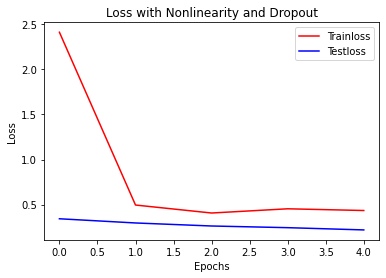

In [8]:
# Visualization

test_loss_array = Tensor(test_loss_array)
train_loss_array = Tensor(train_loss_array)

plt.plot(range(epochs),train_loss_array, label='Trainloss', color = 'red')
plt.plot(range(epochs),test_loss_array, label='Testloss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss with Nonlinearity and Dropout')

In [9]:
# Only Extracting the Dropout

loss_fn = nn.CrossEntropyLoss()
model = MLP() # Without dropout
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
train_loss_array_woutpdrop, test_loss_array_woutpdrop = [],[]

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloaders, model, loss_fn,train_loss_array_woutpdrop, optimizer,l1_lambda=0.0001,l2_lambda=0.001)
    test_loop(test_dataloader, model, loss_fn,test_loss_array_woutpdrop)
print("Done!")

Epoch 1
-------------------------------
loss: 2.417246  [    0/60000]
loss: 0.746493  [10000/60000]
loss: 0.575399  [20000/60000]
loss: 0.661398  [30000/60000]
loss: 0.465500  [40000/60000]
loss: 0.439706  [50000/60000]
Test Error: 
 Accuracy: 91.5%, Avg loss: 0.320047 

Epoch 2
-------------------------------
loss: 0.442300  [    0/60000]
loss: 0.403686  [10000/60000]
loss: 0.511215  [20000/60000]
loss: 0.478545  [30000/60000]
loss: 0.545328  [40000/60000]
loss: 0.366601  [50000/60000]
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.268525 

Epoch 3
-------------------------------
loss: 0.424601  [    0/60000]
loss: 0.483932  [10000/60000]
loss: 0.468768  [20000/60000]
loss: 0.574575  [30000/60000]
loss: 0.399648  [40000/60000]
loss: 0.359474  [50000/60000]
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.239474 

Epoch 4
-------------------------------
loss: 0.444643  [    0/60000]
loss: 0.384457  [10000/60000]
loss: 0.393821  [20000/60000]
loss: 0.298246  [30000/60000]
loss: 0.415817  [40000/6

Text(0.5, 1.0, 'Loss without Dropout')

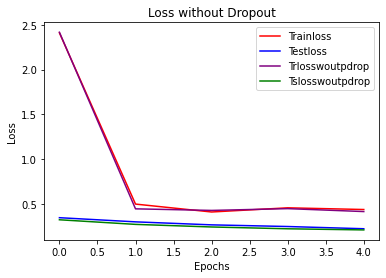

In [10]:
# Visualization

test_loss_array_woutpdrop = Tensor(test_loss_array_woutpdrop)
train_loss_array_woutpdrop = Tensor(train_loss_array_woutpdrop)

plt.plot(range(epochs),train_loss_array, label='Trainloss', color = 'red')
plt.plot(range(epochs),test_loss_array, label='Testloss', color = 'blue')
plt.plot(range(epochs),train_loss_array_woutpdrop, label='Trlosswoutpdrop', color = 'purple')
plt.plot(range(epochs),test_loss_array_woutpdrop, label='Tslosswoutpdrop', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss without Dropout')

Note the following observations
* Training loss is lower without Dropout but test loss is higher without Dropout. This means the model overfitted without Dropout
* The loss convergence is smoother without Dropout, indicating the random noise introduced by Dropout.

In [11]:
# MLP Model without Nonlinearity

class MLP_Identity(nn.Module):
    def __init__(self, input_size = 784, output_size =10, pdrop=0):
        super().__init__()
        self.layer1 = Linear(input_size,64)
        self.layer2 = Linear(64,output_size)
        self.dropout = nn.Dropout(pdrop)

    def forward(self,X):
        X=self.dropout(X)
        X = self.layer1(X)
        X = self.layer2(X)
        return X

    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.pow(w,2).sum()


In [12]:
loss_fn = nn.CrossEntropyLoss()
model = MLP_Identity(pdrop=0.2) # With Dropout
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
train_loss_array_woutnonlin, test_loss_array_woutnonlin = [],[]

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloaders, model, loss_fn,train_loss_array_woutnonlin, optimizer,l1_lambda=0.0001,l2_lambda=0.001)
    test_loop(test_dataloader, model, loss_fn,test_loss_array_woutnonlin)
print("Done!")

Epoch 1
-------------------------------
loss: 2.463857  [    0/60000]
loss: 0.791495  [10000/60000]
loss: 0.485068  [20000/60000]
loss: 0.666346  [30000/60000]
loss: 0.544231  [40000/60000]
loss: 0.455416  [50000/60000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.364830 

Epoch 2
-------------------------------
loss: 0.492007  [    0/60000]
loss: 0.505198  [10000/60000]
loss: 0.508603  [20000/60000]
loss: 0.801441  [30000/60000]
loss: 0.368024  [40000/60000]
loss: 0.487970  [50000/60000]
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.343523 

Epoch 3
-------------------------------
loss: 0.619876  [    0/60000]
loss: 0.488423  [10000/60000]
loss: 0.489813  [20000/60000]
loss: 0.448934  [30000/60000]
loss: 0.610130  [40000/60000]
loss: 0.398318  [50000/60000]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.338867 

Epoch 4
-------------------------------
loss: 0.544497  [    0/60000]
loss: 0.432023  [10000/60000]
loss: 0.482754  [20000/60000]
loss: 0.485790  [30000/60000]
loss: 0.356208  [40000/6

Text(0.5, 1.0, 'Loss without Nonlinearity')

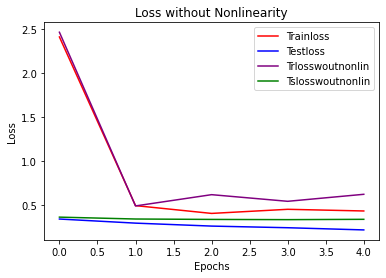

In [13]:
#Visualization

test_loss_array_woutnonlin = Tensor(test_loss_array_woutnonlin)
train_loss_array_woutnonlin = Tensor(train_loss_array_woutnonlin)

plt.plot(range(epochs),train_loss_array, label='Trainloss', color = 'red')
plt.plot(range(epochs),test_loss_array, label='Testloss', color = 'blue')
plt.plot(range(epochs),train_loss_array_woutnonlin, label='Trlosswoutnonlin', color = 'purple')
plt.plot(range(epochs),test_loss_array_woutnonlin, label='Tslosswoutnonlin', color = 'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss without Nonlinearity')

Note the following observations
* Both training and testing losses are higher without nonlinearity
* We see the effect of Dropout in the form of noise in both
* Nonlinearity is more critical than Dropout